In [1]:
%matplotlib inline

import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

sns.set_context("poster")
sns.set_style("darkgrid")

In [2]:
opt_titles = {
    "sgd": "SGD",
    "sgdmomentum": "SGD Momentum",
#     "sgdnesterov": "SGD Nesterov",
    "rmsprop": "RMSProp",
    "adagrad": "AdaGrad",
    "adadelta": "AdaDelta",
    "adam": "Adam",
    "adamax": "Adamax"
}
colors = sns.color_palette("Paired", 9)

# MLNN

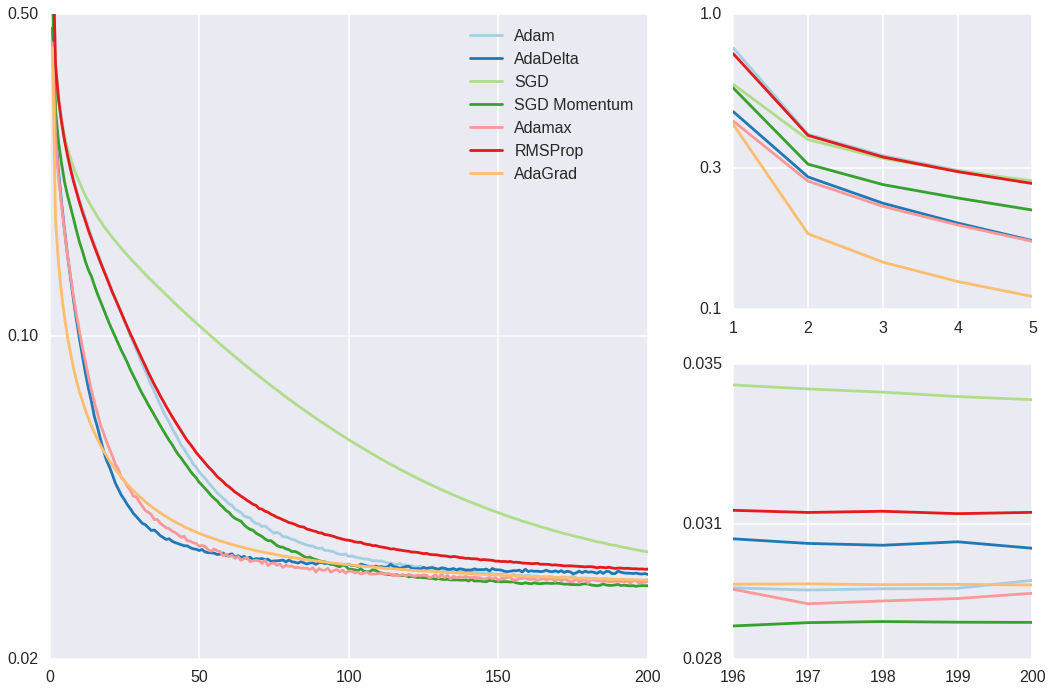

In [3]:
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

for i, (opt, title) in enumerate(opt_titles.items()):
    with open("../data/mlnnexp/{}.pkl".format(opt), "rb") as f:
        loss_history = pickle.load(f)["best_loss_history"]
    ax1.semilogy(range(1, len(loss_history) + 1), loss_history, label=title, color=colors[i])
    ax2.semilogy(range(1, 6), loss_history[:5], color=colors[i])
    ax3.semilogy(range(196, 201), loss_history[-5:], color=colors[i])

for ax in [ax1, ax2, ax3]:
    ax.get_yaxis().get_major_formatter().labelOnlyBase = False
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

ax1.set_ylim(0.02, 0.5)
ax1.set_yticks([0.02, 0.1, 0.5])
ax1.legend()

ax2.set_yticks([0.1, 0.3, 1.0])
ax2.set_xticks(range(1, 6))

ax3.set_ylim(0.028, 0.035)
ax3.set_yticks([0.028, 0.031, 0.035])
ax3.set_xticks(range(196, 201))

fig.tight_layout()